# Objective 2: 3D Image Segmentation

## Import libraries

In [237]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt,  animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2
from skimage import measure



import constants as ct
import utils
from utils import  load_ct_series, load_segmentation, load_pixelarray_positions, reslice_segmentations

## 1.  Extract bounding box and centroid from Tumor mask of Reference Image

- Load segmentation masks and image

In [238]:
slice_liver = ct.LIVER_SEGMENTATION 
slice_tumor = ct.TUMOR_SEGMENTATION 
ct_volume, slice_positions, _ = load_ct_series(ct.REFERENCE_IMAGE)

The reference CT volume has a shape of: (54, 512, 512)


In [239]:
liver_segmented =load_segmentation(slice_liver)
liver_array, liver_pos = load_pixelarray_positions(liver_segmented)
liver_volume = reslice_segmentations(ct_volume.shape,liver_pos,slice_positions, liver_array, label_value=1)


tumor_segmented = load_segmentation(slice_tumor)
tumor_array, tumor_pos = load_pixelarray_positions(tumor_segmented)
tumor_volume = reslice_segmentations(ct_volume.shape,tumor_pos,slice_positions, tumor_array, label_value=2)

In [240]:
ct_volume = np.flip(ct_volume, axis=0) 
liver_volume = np.flip(liver_volume, axis=0)
tumor_volume =  np.flip(tumor_volume, axis=0) 

- Bounding Box (https://www.immersivelimit.com/tutorials/create-bounding-box-from-segmentation)

In [241]:
def extract_bbox(segmentation):
    segmentation = np.where(segmentation > 0)
    z_min = int(np.min(segmentation[0]))
    z_max = int(np.max(segmentation[0]))
    y_min = int(np.min(segmentation[1]))
    y_max = int(np.max(segmentation[1]))
    x_min = int(np.min(segmentation[2]))
    x_max = int(np.max(segmentation[2]))
    return ((z_min,z_max),(y_min, y_max),(x_min, x_max))

In [242]:
liver_bbox = extract_bbox(liver_volume)
print(liver_bbox)
tumor_bbox = extract_bbox(tumor_volume)
print(tumor_bbox)

((6, 37), (106, 315), (85, 405))
((12, 22), (161, 240), (151, 252))


- Centroid (https://github.com/TehseenHasan/yolo5-object-detection-and-centroid-finding/blob/main/yolo5_detection.py)

In [243]:
def centroid(bbox): 
    z_min, z_max = bbox[0]
    y_min, y_max = bbox[1]
    x_min, x_max = bbox[2]

    cz = int((z_min+z_max)/2.0)
    cy = int((y_min+y_max)/2.0) 
    cx = int((x_min+x_max)/2.0)

    return (cz, cy, cx)

In [244]:
liver_centroid = centroid(liver_bbox)
print(liver_centroid)
tumor_centroid = centroid(tumor_bbox)
print(tumor_centroid)

(21, 210, 245)
(17, 200, 201)


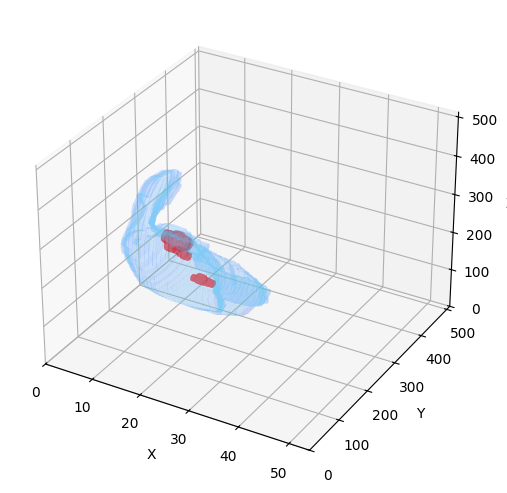

In [245]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Liver mesh
verts_liver, faces_liver, _, _ = measure.marching_cubes(liver_volume, level=0.5)
mesh_liver = Poly3DCollection(verts_liver[faces_liver], alpha=0.2)
mesh_liver.set_facecolor([0.5, 0.8, 1.0])  # Light blue
ax.add_collection3d(mesh_liver)

# Tumor mesh
verts_tumor, faces_tumor, _, _ = measure.marching_cubes(tumor_volume, level=0.5)
mesh_tumor = Poly3DCollection(verts_tumor[faces_tumor], alpha=0.6)
mesh_tumor.set_facecolor([1, 0, 0])  # Red
ax.add_collection3d(mesh_tumor)

# Set limits
max_shape = np.max([liver_volume.shape, tumor_volume.shape], axis=0)
ax.set_xlim(0, max_shape[0])
ax.set_ylim(0, max_shape[1])
ax.set_zlim(0, max_shape[2])

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

## 3.  Visualization and Assessment

In [246]:
def plot_ct_and_segmentation(mask, id, type, alpha):
    if(type== 'coronal'):
        slice_ct = ct_volume[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_ct = ct_volume[:,:,id]
        slice_auto = mask[:,:,id]
    
    img_min = np.min(slice_ct)
    img_max = np.max(slice_ct)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    cm = matplotlib.colormaps['prism']
    mask_bone_cmapped = cm(slice_auto)
    mask_bone_cmapped = mask_bone_cmapped * \
        (slice_auto > 0)[..., np.newaxis].astype('bool')
    
    cm = matplotlib.colormaps['bone']
    img_cmapped = cm(slice_ct)

    axs[0].imshow(slice_ct,vmin=img_min,vmax= img_max, cmap='bone', aspect=(5.0/ 0.703125))
    axs[0].set_title('CT Image')

    axs[1].imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, vmin=img_min,vmax= img_max,cmap='bone',aspect=(5.0/ 0.703125))
    axs[1].set_title('CT + Mask')

    plt.show()

def plot_gt_and_segmentation(mask, gt, id, type):
    if(type== 'coronal'):
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_gt = gt[:,:,id]
        slice_auto = mask[:,:,id]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    overlay = np.zeros((*slice_gt.shape, 3), dtype=np.float32)
    overlay[:, :, 0] = slice_gt & ~slice_auto
    overlay[:, :, 1] = ~slice_gt & slice_auto
    overlay[:, :, 2] = slice_gt & slice_auto

    axs[0].imshow(slice_gt,cmap='gray', aspect=(5.0/ 0.703125))
    axs[0].set_title('Groud Truth')

    axs[1].imshow(slice_auto,cmap='gray',aspect=(5.0/ 0.703125))
    axs[1].set_title('Mask')
    
    
    overlay = np.clip(overlay, 0, 1)
    axs[2].imshow(overlay,aspect=(5.0/ 0.703125))
    axs[2].set_title('Comparison: Red -> GT, Green -> Segmentation, Blue -> Union')
    plt.show()

def plot_all(mask, gt, id, type, alpha):
    if(type== 'coronal'):
        slice_ct = ct_volume[:,id,:]
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_ct = ct_volume[:,:,id]
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,:,id]
    
    img_min = np.min(slice_ct)
    img_max = np.max(slice_ct)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
   
    
    cm = matplotlib.colormaps['bone']
    img_cmapped = cm(slice_ct)

    cm = matplotlib.colormaps['Set1']
    mask_bone_cmapped = cm(slice_auto)
    mask_bone_cmapped = mask_bone_cmapped * \
        (slice_auto > 0)[..., np.newaxis].astype('bool')
    
    gt_cmapped = cm(slice_gt)
    gt_cmapped = gt_cmapped * \
        (slice_gt > 0)[..., np.newaxis].astype('bool')

    axs[0].imshow(img_cmapped * (1-alpha) + gt_cmapped * alpha,vmin=img_min,vmax= img_max, cmap='bone', aspect=(5.0/ 0.703125))
    axs[0].set_title('CT Image')


    axs[1].imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, vmin=img_min,vmax= img_max,cmap='bone',aspect=(5.0/ 0.703125))
    axs[1].set_title('CT + Mask')
    

    overlay = np.zeros_like(slice_gt, dtype=np.float32)
    overlay[(slice_gt == 2) & (slice_auto ==1)]=1
    overlay[(slice_gt == 0) & (slice_auto ==1)]=2
    overlay[(slice_gt == 2) & (slice_auto ==0)]=3


    overlay_cmapped = cm(overlay)
    overlay_cmapped = overlay_cmapped * \
        (overlay > 0)[..., np.newaxis].astype('bool')

    axs[2].imshow(img_cmapped * (1-alpha) + overlay_cmapped * alpha, vmin=img_min,vmax= img_max,aspect=(5.0/ 0.703125))
    axs[2].set_title('')

    plt.show()



In [247]:
def perpixel_performance_measures(
        mask_reference: np.ndarray,
        mask_prediction: np.ndarray
        ) -> tuple[int, int, int, int]:
    """ Compute the number of true/false positives and true/false negatives from two boolean masks."""
    # Your code here:
    #   ...
    true_negatives = np.sum((mask_reference == 0) & (mask_prediction == 0))
    true_positives = np.sum((mask_reference == 1) & (mask_prediction == 1))
    false_negatives = np.sum((mask_reference == 1) & (mask_prediction == 0))
    false_positives = np.sum((mask_reference == 0) & (mask_prediction == 1))
    return true_positives, true_negatives, false_positives, false_negatives

In [248]:
def perimage_performance_measures(mask_reference, mask_prediction):
    """ Compute the sensitivity, specificity and f1_score from two boolean masks. """
    # Your code here:
    #   ...
    tp, tn, fp, fn = perpixel_performance_measures(mask_reference, mask_prediction)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, f1_score

In [249]:
def dice_coefficient(mask_reference, mask_prediction):
    intersection = np.sum(mask_reference * mask_prediction)
    return (2. * intersection) / (np.sum(mask_reference) + np.sum(mask_prediction))


## 2.  Segmentation

### Thresholding 

In [250]:
print(np.max(ct_volume))
print(np.min(ct_volume))

3071
-1024


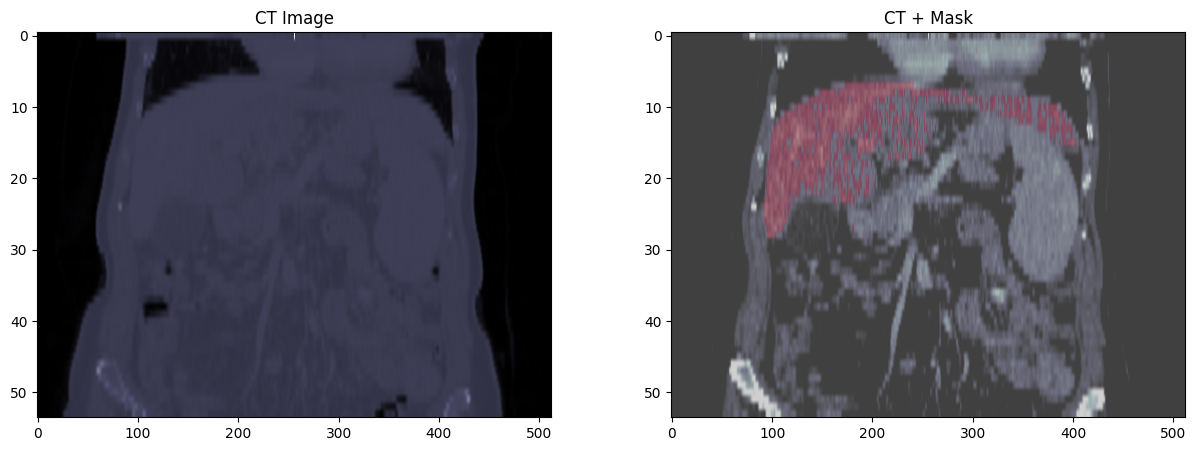

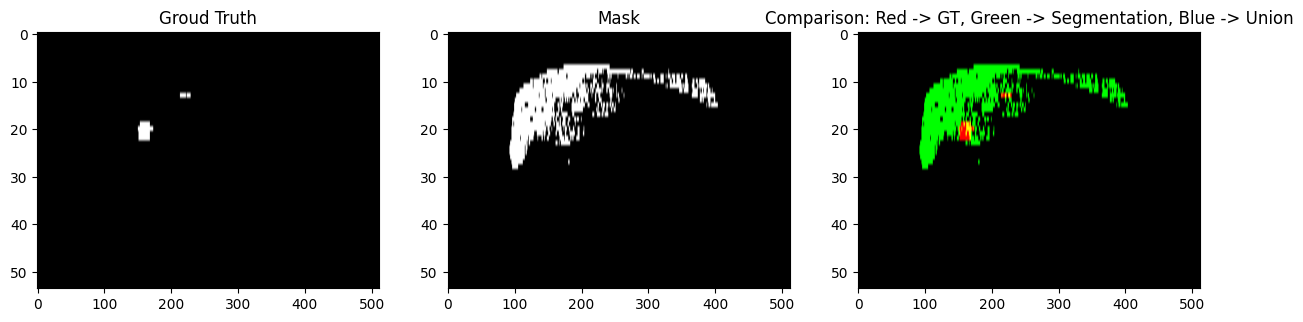

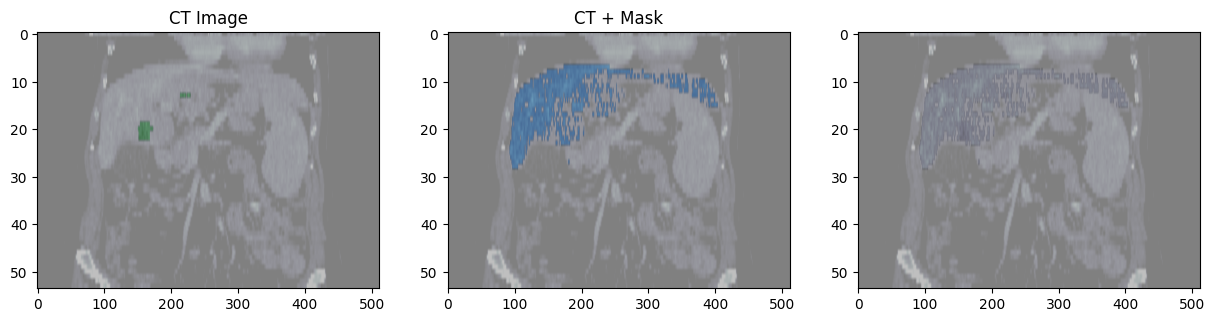

In [251]:
ret, binary_mask = cv2.threshold(ct_volume, 100, 171, cv2.THRESH_BINARY)
final_mask = binary_mask & (liver_volume > 0)

plot_ct_and_segmentation(final_mask,200,'coronal',0.25)
plot_gt_and_segmentation(final_mask,tumor_volume,200,'coronal')
plot_all(final_mask,tumor_volume,200,'coronal',0.5)

In [252]:
print(perpixel_performance_measures(tumor_volume,final_mask))
print(perimage_performance_measures(tumor_volume, final_mask))
print(dice_coefficient(tumor_volume, final_mask))

(np.int64(0), np.int64(13802767), np.int64(346667), np.int64(0))
(np.float64(nan), np.float64(0.9754995853544389), np.float64(0.0))
0.027767414739832477


C:\Users\Aina\AppData\Local\Temp\ipykernel_38648\3083131473.py:6: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


### Region Growing

In [253]:
from scipy.ndimage import label
labeled_mask, num_labels = label(tumor_volume)
print(num_labels)
print(np.unique(labeled_mask)) 

bboxes = []
for i in range(1,4):
    bboxes.append(extract_bbox(labeled_mask==i))

print(len(bboxes))

centroids = []
for i in range(0,3):
    centroids.append(centroid(bboxes[i]))

print(len(centroids))

3
[0 1 2 3]
3
3


In [254]:
from skimage.segmentation import flood
masks=[]
for c in centroids:
    mask=flood(ct_volume, c, tolerance=3) 
    masks.append(mask)
    print(np.sum(mask))

76522
44
59


In [255]:
combined_mask = np.any(masks, axis=0)
final_mask = combined_mask & (liver_volume > 0)

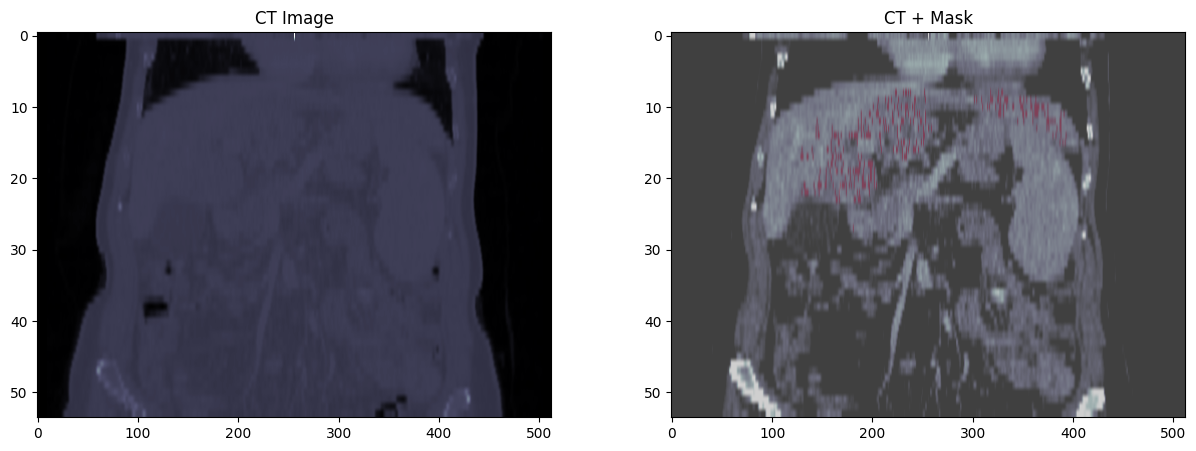

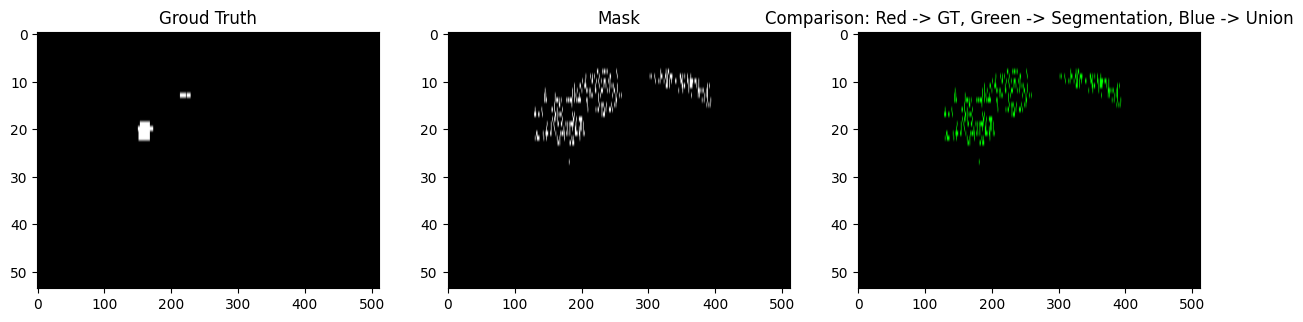

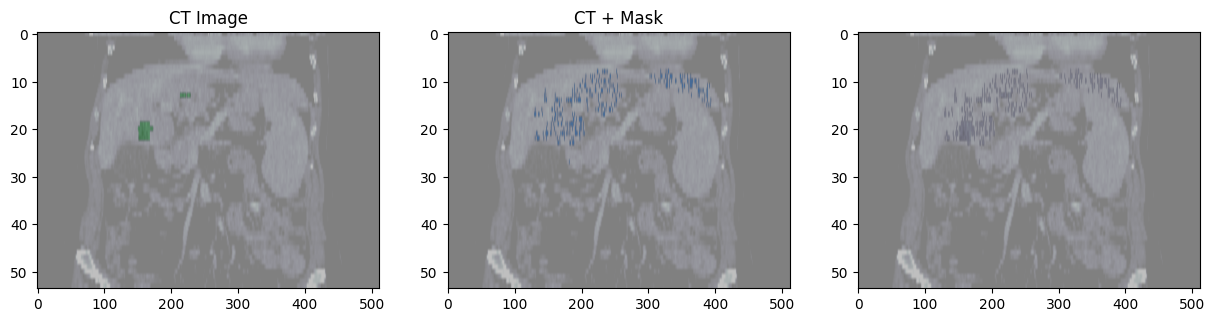

In [256]:
plot_ct_and_segmentation(final_mask,200,'coronal',0.25)
plot_gt_and_segmentation(final_mask,tumor_volume,200,'coronal')
plot_all(final_mask,tumor_volume,200,'coronal',0.5)

In [257]:
print(perpixel_performance_measures(tumor_volume, mask[1]))
print(perimage_performance_measures(tumor_volume, final_mask))
print(dice_coefficient(tumor_volume, final_mask))

(np.int64(0), np.int64(14149434), np.int64(0), np.int64(0))
(np.float64(nan), np.float64(0.9967536510647705), np.float64(0.0))
0.08024340499515197


C:\Users\Aina\AppData\Local\Temp\ipykernel_38648\3083131473.py:6: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


# IN PROGRESS

In [258]:
full_mask = np.zeros_like(ct_volume, dtype=bool)
for b, m in zip(bboxes, masks):
    (zmin,zmax), (ymin, ymax), (xmin, xmax) = b[0], b[1], b[2]
    full_mask[zmin:zmax, ymin:ymax, xmin:xmax] = m

ValueError: could not broadcast input array from shape (54,512,512) into shape (4,40,49)

In [ ]:
for b in bboxes: 
    (zmin,zmax), (ymin, ymax), (xmin, xmax) = b[0], b[1], b[2]
    ct_crop = ct_volume[zmin:zmax, ymin:ymax, xmin:xmax]
    centroid_crop = (tumor_centroid[0] - zmin, tumor_centroid[1] - ymin, tumor_centroid[2] - xmin)